In [4]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-rhprice2.0-rhfleet1.0-20220905/beam/year-2018-iteration-5/ITERS/it.0/0.events.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
dtypes = {
    "time": "float32",
    "type": "category",
    "legMode": "category",
    "actType": "category", 
    "primaryFuelLevel": "float64",
    "legMode": "category",
    "chargingPointType":"category",
    "pricingModel":"category",
    "parkingType":"category",
    "mode":"category",
    "personalVehicleAvailable": "category",
    "person": "object",
    "driver": "object",
    "riders": "object",
    'primaryFuelType': "category",
    'secondaryFuelType': 'category',
    'currentTourMode': 'category',
    'currentActivity': 'category',
    'nextActivity': 'category'    
}
eventsSF = pd.read_csv(obj['Body'], compression = 'gzip', dtype = dtypes)

<timed exec>:25: DtypeWarning: Columns (17,22,23,37,41,42,46,48) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 24s
Wall time: 3min 24s


In [6]:
key = "pilates-outputs/sfbay-rhprice2.0-rhfleet1.0-20220905/activitysim/year-2018-iteration-5/final_trips.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
trips = pd.read_csv(obj['Body'], compression = 'gzip')

In [7]:
%%time
baseline2018 = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Ridehail_Price/"
sfbase = pd.read_csv(baseline2018 + 'sf_2018_rh_price_2.csv')

<timed exec>:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 32s
Wall time: 4min 17s


In [8]:
eventsSF.head()

,mode,currentTourMode,driver,vehicle,riders,toStopIndex,fromStopIndex,seatingCapacity,tollPaid,primaryFuelLevel,endY,endX,startY,startX,capacity,arrivalTime,departureTime,linkTravelTime,secondaryFuel,secondaryFuelType,primaryFuelType,secondaryFuelLevel,vehicleType,links,numPassengers,length,primaryFuel,time,type,person,incentive,tollCost,netCost,link,facility,actType,expectedMaximumUtility,availableAlternatives,location,personalVehicleAvailable,tourIndex,legModes,legVehicleIds,currentActivity,nextActivity,tripId,reason,price,parkingTaz,chargingPointType,pricingModel,parkingType,locationY,locationX,departTime,legMode,cost,shiftStatus,parkingZoneId,fuel,duration,score
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,departure,TransitDriverAgent-SF:7590302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be_a_transit_driver,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,departure,TransitDriverAgent-3D:309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be_a_transit_driver,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,departure,TransitDriverAgent-SF:7606357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be_a_transit_driver,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,departure,TransitDriverAgent-CC:31002002_merged_421003228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be_a_transit_driver,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,SF:7606357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,PersonEntersVehicle,TransitDriverAgent-SF:7606357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
trips.head()

,trip_id,person_id,household_id,tour_id,primary_purpose,trip_num,outbound,trip_count,purpose,destination,origin,destination_logsum,depart,trip_mode,mode_choice_logsum
0,578577,1763,1017873,72322,work,1,True,1,work,383,1414,NaN,7.0,DRIVEALONEFREE,-3.257341
1,578581,1763,1017873,72322,work,1,False,1,Home,1414,383,NaN,19.0,DRIVEALONEPAY,-3.297603
2,578593,1764,1017873,72324,atwork,1,True,1,atwork,1346,1337,NaN,14.0,SHARED3FREE,2.017269
3,578597,1764,1017873,72324,atwork,1,False,1,Work,1337,1346,NaN,14.0,SHARED3PAY,-0.272944
4,578905,1764,1017873,72363,work,1,True,1,work,1337,1414,NaN,9.0,DRIVEALONEFREE,-0.648293


In [15]:
sfbase.head()

,IDMerged,tripIndex,BlockGroupEnd,BlockGroupStart,actEndTime,actEndType,actStartTime,actStartType,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emissionBiodiesel,emissionDiesel,emissionElectricity,emissionFood,emissionGasoline,emission_marginal,fuelBiodiesel,fuelDiesel,fuelElectricity,fuelFood,fuelGasoline,fuel_marginal,fuel_not_Food,vehicleIds_estimate,lever,lever_position,mode_choice_actual_BEAM,mode_choice_planned_BEAM,numPassengers,parkingType,reason,replanning_status,ride_hail_pooled,scenario,transit_bus,transit_cable_car,transit_rail,transit_subway,transit_tram,vehicleIds,year,duration_door_to_door,waitTime,actPurpose,mode_choice_actual_5,mode_choice_actual_6,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_mode_AS_trips,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,earning,worker,student,hispanic.1,person_sex,PNUM,sex,household_id_y,hours,MAR,person_age,edu,school_zone_id,race_id,race,work_at_home,age,work_zone_id,p_hispanic,relate,hispanic,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,gt55,seniors,VEHICL,lcm_county_id,hh_children,block_id,gt2,hispanic_head,age_of_head,race_of_head,tenure_mover,hh_size,sf_detached,tenure,hh_cars,income,hh_age_of_head,serialno,num_workers,hh_race_of_head,hh_income,recent_mover,hh_workers,hispanic_status_of_head,hh_seniors,hhsize,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
0,1,577.0,6.085503e+10,6.085504e+10,30362.0,Home,30643.0,othmaint,0.000000,0.0,6682.954,6682.954,0.0,0.0,6682.954,0.000,281.0,0.0,0.0,0.0,281.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,"body-1,teleportationSharedVehicle-1-1,body-1",price,2,hov2_teleportation,hov2_teleportation,NaN,NaN,NaN,0,0,ridehail,0,0,0,0,0,NaN,2018,281.0,0.0,Home_to_othmaint,car,car,

In [30]:
sfbase[sfbase['mode_choice_planned_BEAM'] != sfbase['mode_choice_actual_BEAM']].head()

,IDMerged,tripIndex,BlockGroupEnd,BlockGroupStart,actEndTime,actEndType,actStartTime,actStartType,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emissionBiodiesel,emissionDiesel,emissionElectricity,emissionFood,emissionGasoline,emission_marginal,fuelBiodiesel,fuelDiesel,fuelElectricity,fuelFood,fuelGasoline,fuel_marginal,fuel_not_Food,vehicleIds_estimate,lever,lever_position,mode_choice_actual_BEAM,mode_choice_planned_BEAM,numPassengers,parkingType,reason,replanning_status,ride_hail_pooled,scenario,transit_bus,transit_cable_car,transit_rail,transit_subway,transit_tram,vehicleIds,year,duration_door_to_door,waitTime,actPurpose,mode_choice_actual_5,mode_choice_actual_6,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_mode_AS_trips,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,earning,worker,student,hispanic.1,person_sex,PNUM,sex,household_id_y,hours,MAR,person_age,edu,school_zone_id,race_id,race,work_at_home,age,work_zone_id,p_hispanic,relate,hispanic,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,gt55,seniors,VEHICL,lcm_county_id,hh_children,block_id,gt2,hispanic_head,age_of_head,race_of_head,tenure_mover,hh_size,sf_detached,tenure,hh_cars,income,hh_age_of_head,serialno,num_workers,hh_race_of_head,hh_income,recent_mover,hh_workers,hispanic_status_of_head,hh_seniors,hhsize,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
766,2555,838289.0,6.001404e+10,6.013353e+10,28162.0,Home,30637.0,school,1.487059,0.000,26396.283000,12488.696,0.0,0.000000,14524.817000,2036.121000,571.0,0.0,0.0,0.0,2137.0,1566.0,0.000000,0.0,0.0,0.0,0.001083,0.0,0.000000e+00,0.0,0.0,107914.4130,1.465342e+07,1.476134e+07,1.465342e+07,"body-2555,rideHailVehicle-1443532@default,body...",price,2,car,ride_hail_pooled,"1.0, 1.0, 0.0, 0.0, 1.0","Residential,

In [33]:
#sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['Realized_INEXUS_in_dollar'] <-20000)].head()

In [13]:
wTime = sfbase[['IDMerged', 'tripIndex','end','start','duration', 'household_id','actPurpose',
               'waitTime', 'duration_travelling', 'duration_door_to_door','mode_choice_actual_BEAM']]

In [22]:
wTime[wTime['IDMerged']== 1583162]

,IDMerged,tripIndex,end,start,duration,household_id,actPurpose,waitTime,duration_travelling,duration_door_to_door,mode_choice_actual_BEAM
533826,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,921.0,172.0,1093.0,ride_hail_pooled
533827,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,895.0,168.0,1063.0,ride_hail_pooled


In [24]:
rh_wTime = wTime[(wTime['mode_choice_actual_BEAM'] == 'ride_hail')|(wTime['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

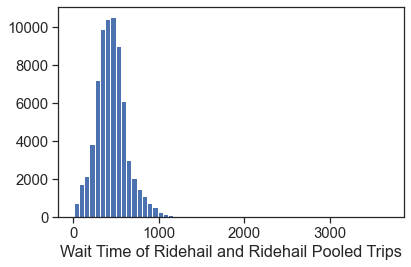

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.hist(rh_wTime['waitTime'], bins=60)
ax.set_xlabel('Wait Time of Ridehail and Ridehail Pooled Trips')
fig.tight_layout()